In [1]:
!pip install xgboost


In [3]:
import os
import numpy as np
import librosa
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

In [4]:
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def change_speed(data, sample_rate, speed_factor=1.0):
    new_sample_rate = int(sample_rate * speed_factor)
    return librosa.resample(data, orig_sr=sample_rate, target_sr=new_sample_rate)

In [6]:
def extract_features(file_path, augment=False):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    
    if augment:
        # Randomly choose an augmentation
        aug_type = random.choice(['noise', 'speed', 'none'])
        if aug_type == 'noise':
             audio = add_noise(audio)
        elif aug_type == 'speed':
            speed_factor = random.uniform(0.9, 1.1)
            audio = change_speed(audio, sample_rate, speed_factor)
    
    # Longer MFCC with 60 coefficients
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    log_mel = librosa.power_to_db(mel)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    
    features = np.hstack([
        np.mean(mfccs.T, axis=0),
        np.mean(chroma.T, axis=0),
        np.mean(log_mel.T, axis=0),
        np.mean(contrast.T, axis=0),
        np.mean(zcr.T, axis=0)
    ])
    return features 

In [8]:
def load_data(data_path, augment_factor=2):
    features_list = []
    labels = []
    
    # Allowed emotions (filter)
    allowed_emotions = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry'}
    
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                emotion_code = int(file.split("-")[2])
                emotion = allowed_emotions.get(emotion_code)
                if emotion is None:
                    continue
                
                # Original audio feature
                features = extract_features(file_path, augment=False)
                features_list.append(features)
                labels.append(emotion)
                
                # Augmented features (multiply data)
                for _ in range(augment_factor):
                    aug_features = extract_features(file_path, augment=True)
                    features_list.append(aug_features)
                    labels.append(emotion)
                    
    return np.array(features_list), np.array(labels)

In [9]:
data_path = r"C:\Users\Thaar\OneDrive\Desktop\project 1\voice_recordings"  # Change to your dataset path
print("Loading data and extracting features with augmentation... This can take some time.")

X, y = load_data(data_path, augment_factor=2)  # You get 3x data: original + 2 augmented
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)                                                                           

Loading data and extracting features with augmentation... This can take some time.


C:\Users\Thaar\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Thaar\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Thaar\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Data shape: (2592, 208), Labels shape: (2592,)


In [10]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)

grid_search = GridSearchCV(xgb, param_grid, cv=3, verbose=2, n_jobs=-1)
print("Starting Grid Search for XGBoost hyperparameters...")
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Starting Grid Search for XGBoost hyperparameters...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\Thaar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:49:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}


In [11]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Testing Accuracy: {test_acc*100:.2f}%")

y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Training Accuracy: 100.00%
Testing Accuracy: 84.97%
Classification Report:
               precision    recall  f1-score   support

       angry       0.95      0.95      0.95       115
        calm       0.78      0.90      0.84       115
       happy       0.83      0.91      0.87       116
     neutral       0.90      0.64      0.75        58
         sad       0.83      0.74      0.78       115

    accuracy                           0.85       519
   macro avg       0.86      0.83      0.84       519
weighted avg       0.85      0.85      0.85       519



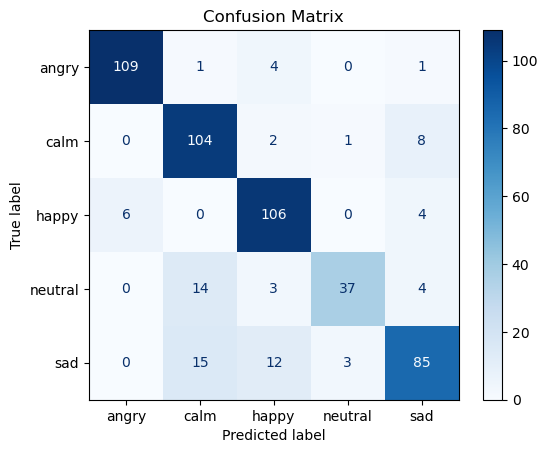

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()